Dear Denis, this file contains the original codes of AESM1455 and below my try on solving the system using full fractional flow.

In [49]:
import numpy as np
#import torch as tr
import timeit
import matplotlib.pyplot as plt

def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")
        
def vecprint(x, fmt="g"):
    for i, y in enumerate(x):
        print(("{:"+str(i)+fmt+"}").format(y), end="  ")
    print("")    

one_d = True

#setting geometry
nx = 5
ny = 1

nb = nx * ny # number of blocks
nc = 2    # number of equations/unknowns
Theta = 1  # V phi dx / k A dt

#well settings
p_inj = 200
p_prod = 100
#s_inj = 0.9

    #added
z_inj = 0.99



#well locations
i_inj = 0
i_prod = nb-1

#setting initial conditions
#s = np.ones(nb)*0.1
p = np.ones(nb)*150

    #added
z = np.ones(nb) * 0.01


#reservoir parameters
p_0 = 1
c_o = 1e-5
c_w = 1e-5
c_g = 1e-5
rho_o0 = 20
rho_g0 = 20
rho_w0 = 10
mu_o = 2                  #viscosity
mu_w = 1                  #viscosity
mu_g = 2
n_o = 2                   #
n_w = 2                   #
n_g = 2




In [50]:
def RachfordRice(z1):

    z = np.array([z1, 1-z1])
    K = np.array([3, 0.1])
    r = lambda v: np.sum(z*(K-1)/(v*(K-1)+1))
    a = 1 / (1 - np.max(K))
    b = 1 / (1 - np.min(K))

    for i in range(1000):
        v = 0.5 * (a + b)
        if r(v) > 0:
            a = v
        else:
            b = v

        if np.abs(r(v)) < 1e-12:
            break

    x = z/(v*(K-1)+1)
    y = K * x

    return x, y

x, y = RachfordRice(z_inj)

In [51]:
#Original functions of AESM1455

rho_w = lambda p: rho_w0 * (1+c_w*(p-p_0))
rho_o = lambda p: rho_o0 * (1+c_o*(p-p_0))
rho_g = lambda p: rho_g0 * (1+c_g*(p-p_0))

#saturation equation, x and y are always x[0] and y[0] in binary system

a = dict([(0, lambda p, s: rho_w(p) * s),
          (1, lambda p, s: rho_o(p)* (1-s))])

b = dict([(0, lambda p, s: rho_w(p) * s**n_w / mu_w),
          (1, lambda p, s: rho_o(p)* (1-s)**n_o / mu_o)])

da_dp = dict([(0, lambda p, s: s* rho_w0 *c_w),
              (1, lambda p, s: (1-s)* rho_o0 *c_o)])
da_ds = dict([(0, lambda p, s: rho_w(p)),
              (1, lambda p, s: -rho_o(p))])
db_dp = dict([(0, lambda p, s: rho_w0 *c_w * s**n_w / mu_w),
              (1, lambda p, s: rho_o0 * c_o * (1-s)**n_o / mu_o)])
db_ds = dict([(0, lambda p, s: rho_w(p) * n_w * s**(n_w-1) / mu_w),
              (1, lambda p, s: -rho_o(p)*n_o * (1-s)**(n_o-1) / mu_o)])

bh = lambda j, pl, sl, pr, sr: b[j](pl, sl) if pl > pr else b[j](pr, sr)

dbh_dpl = lambda j, pl, sl, pr, sr: db_dp[j](pl,sl) if pl > pr else 0
dbh_dpr = lambda j, pl, sl, pr, sr: db_dp[j](pr,sr) if pl < pr else 0
dbh_dsl = lambda j, pl, sl, pr, sr: db_ds[j](pl,sl) if pl > pr else 0
dbh_dsr = lambda j, pl, sl, pr, sr: db_ds[j](pr,sr) if pl < pr else 0

In [52]:
#Original functions of AESM1455

def jac_rhs_analytic_conn(vars, vars_n):
    jac = np.zeros((nc*nb,nc*nb))
    rhs = np.zeros(nc*nb)
    p = vars[0::nc]
    s = vars[1::nc]
    pn = vars[0::nc]
    sn = vars[1::nc]
    
    for j in [0,1]:
        for i in range(nb):
            rhs[nc* i + j] = Theta * (a[j](p[i], s[i]) - a[j](pn[i], sn[i]))
            
            jac[nc* i + j, nc * i + 0] = Theta * da_dp[j](p[i], s[i])
            jac[nc* i + j, nc * i + 1] = Theta * da_ds[j](p[i], s[i])
        
        for k in range (nconns):
            l = lb[k]
            r = rb[k]
            G = Trans[k]
            
            Qk = G * bh(j, p[l], s[l], p[r], s[r]) * (p[l] - p[r])
            
            rhs[nc * l + j] += Qk
            rhs[nc * r + j] -= Qk
            
            dQk_dpl = G *dbh_dpl(j, p[l], s[l], p[r], s[r]) * (p[l] - p[r]) + G * bh(j, p[l], s[l], p[r], s[r])
            dQk_dpr = G *dbh_dpr(j, p[l], s[l], p[r], s[r]) * (p[l] - p[r]) - G * bh(j, p[l], s[l], p[r], s[r])
            
            jac[nc* l + j, nc * l + 0] += dQk_dpl
            jac[nc* l + j, nc * r + 0] += dQk_dpr 
            
            jac[nc* r + j, nc * l + 0] -= dQk_dpl
            jac[nc* r + j, nc * r + 0] -= dQk_dpr 
            
            dQk_dsl = G *dbh_dsl(j, p[l], s[l], p[r], s[r]) * (p[l] - p[r])
            dQk_dsr = G *dbh_dsr(j, p[l], s[l], p[r], s[r]) * (p[l] - p[r])
            
            jac[nc* l + j, nc * l + 1] += dQk_dsl
            jac[nc* l + j, nc * r + 1] += dQk_dsr 
            
            jac[nc* r + j, nc * l + 1] -= dQk_dsl             
            jac[nc* r + j, nc * r + 1] -= dQk_dsr 
            
    add_injector(rhs, p, s, i_inj)
    add_producer(rhs, p, s, i_prod)
    add_injector_to_jac(rhs, jac, p, s, i_inj)
    add_producer_to_jac(rhs, jac, p, s, i_prod)
    
    return rhs, jac

In the box below, I've changed beta to fractional flow equation (eq. 18). I've also changed the alpha operator, as it is different for compositional flow. I also did not see the point of the dictionary system anymore, as I'm not solving it for two-phase but for two components. What could go wrong is that I should not have adjusted my alpha or that I wrongly added a pressure factor to the beta operator.

In [53]:
#functions for compositional flow:

rho_w = lambda p: rho_w0 * (1+c_w*(p-p_0))
rho_o = lambda p: rho_o0 * (1+c_o*(p-p_0))
rho_g = lambda p: rho_g0 * (1+c_g*(p-p_0))

# third try with fractional flow
# added for comp flow
s = lambda z : (z - y[0]) / (x[0] - y[0])
f = lambda s: s**2 / (s**2 + 10.*(1-s)**2)


df_ds = lambda s: (f(s + 1e-8) - f(s)) / 1e-8 if s > 0 and s < 1 else 0

#new alpha operator based on eq. 33
a2 = lambda p, z: rho_o(p) * z

da_dp2 = lambda p, z: z* rho_o0 *c_o
da_dz =  lambda p, z: rho_o(p)

#new beta operator, fractional flow based. Added rho_o to get a pressure component (eq. 18)
b3 = lambda p, z: rho_o(p) * (x[0] * f(s(z)) + y[0]*(1-f(s(z))))

#new beta derivatives, fractional flow based. Added rho_o to get a pressure component (eq. 43)

db_dp3 = lambda p, z: (rho_o0 *c_o)* (x[0] * f(s(z)) + y[0]*(1-f(s(z))))
db_dz2 = lambda p, z:( (x[0]-y[0])*df_ds(s(z)) ) * ( 1/(x[0]-y[0])) if s(z) > 0 and s(z) < 1 else 1

bh3 = lambda  pl, zl, pr, zr: b3(pl, zl) if pl > pr else b3(pr, zr)

dbh_dpl3 = lambda  pl, zl, pr, zr: db_dp3(pl,zl) if pl > pr else 0
dbh_dpr3 = lambda  pl, zl, pr, zr: db_dp3(pr,zr) if pl < pr else 0
dbh_dzl2 = lambda  pl, zl, pr, zr: db_dz2(pl,zl) if pl > pr else 0
dbh_dzr2 = lambda  pl, zl, pr, zr: db_dz2(pr,zr) if pl < pr else 0

In the box below, I've only replaced the old functions with the new ones here.

In [54]:
def add_injector2(rhs, p, z, i):
    
    rhs[nc * i] += b3(p_inj, z_inj) * (p[i] - p_inj)
        
def add_producer2(rhs, p, z, i):
    
    rhs[nc * i] += b3(p[i], z[i]) * (p[i] - p_prod)
        
def add_injector_to_jac2(rhs, jac, p, z, i):
    
    rhs[nc * i] += b3(p_inj, z_inj) * (p[i] - p_inj)
    jac[nc * i, nc * i + 0] += b3(p_inj, z_inj)
        
def add_producer_to_jac2(rhs, jac, p, z, i):
    
    rhs[nc * i] += b3(p[i], z[i]) * (p[i] - p_prod)
    jac[nc * i, nc * i + 0] += b3(p[i], z[i]) + db_dp3(p[i],z[i]) * (p[i] - p_prod)
    jac[nc * i, nc * i + 1] += db_dz2(p[i],z[i]) * (p[i] - p_prod)
        

For the connection based function, I've just updated the formulas to the new formulas with the right inputs. I thought that an issue could be that the Jacobian is set up wrongly, but i don't know what it should be else exactly..

In [47]:
def jac_rhs_analytic_conn3(vars, vars_n, Theta):
    jac = np.zeros((nc*nb,nc*nb))
    rhs = np.zeros(nc*nb)
    p = vars[0::nc]
    z = vars[1::nc]
    pn = vars[0::nc]
    zn = vars[1::nc]
    
    for j in [0,1]:    
        for i in range(nb):
            rhs[nc* i+ j] = Theta * (a2[j](p[i], z[i]) - a2[j](pn[i], zn[i]))

            jac[nc* i+ j, nc * i + 0] = Theta * da_dp2[j](p[i], z[i])
            jac[nc* i+ j, nc * i + 1] = Theta * da_dz[j](p[i], z[i])

        for k in range (nconns):
            l = lb[k]
            r = rb[k]
            G = Trans[k]

            Qk = G * bh3(j, p[l], z[l], p[r], z[r]) * (p[l] - p[r])

            rhs[nc * l+ j] += Qk
            rhs[nc * r+ j] -= Qk

            dQk_dpl = G *dbh_dpl3(j, p[l], z[l], p[r], z[r]) * (p[l] - p[r]) + G * bh3(j, p[l], z[l], p[r], z[r])
            dQk_dpr = G *dbh_dpr3(j, p[l], z[l], p[r], z[r]) * (p[l] - p[r]) - G * bh3(j, p[l], z[l], p[r], z[r])

            jac[nc* l+ j, nc * l + 0] += dQk_dpl
            jac[nc* l+ j, nc * r + 0] += dQk_dpr 

            jac[nc* r+ j, nc * l + 0] -= dQk_dpl
            jac[nc* r+ j, nc * r + 0] -= dQk_dpr 

            dQk_dzl = G *dbh_dzl2(j, p[l], z[l], p[r], z[r]) * (p[l] - p[r])
            dQk_dzr = G *dbh_dzr2(j, p[l], z[l], p[r], z[r]) * (p[l] - p[r])

            jac[nc* l+ j, nc * l + 1] += dQk_dzl
            jac[nc* l+ j, nc * r + 1] += dQk_dzr 

            jac[nc* r+ j, nc * l + 1] -= dQk_dzl             
            jac[nc* r+ j, nc * r + 1] -= dQk_dzr 
            
    add_injector2(rhs, p, z, i_inj)
    add_producer2(rhs, p, z, i_prod)
    add_injector_to_jac2(rhs, jac, p, z, i_inj)
    add_producer_to_jac2(rhs, jac, p, z, i_prod)
    
    return rhs, jac

In [ ]:
def jac_rhs_analytic_conn3(vars, vars_n, Theta):
    jac = np.zeros((nc*nb,nc*nb))
    rhs = np.zeros(nc*nb)
    p = vars[0::nc]
    z = vars[1::nc]
    pn = vars[0::nc]
    zn = vars[1::nc]
    
    
    for i in range(nb):
        rhs[nc* i] = Theta * (a2(p[i], z[i]) - a2(pn[i], zn[i]))

        jac[nc* i, nc * i + 0] = Theta * da_dp2(p[i], z[i])
        jac[nc* i, nc * i + 1] = Theta * da_dz(p[i], z[i])

    for k in range (nconns):
        l = lb[k]
        r = rb[k]
        G = Trans[k]

        Qk = G * bh3(p[l], z[l], p[r], z[r]) * (p[l] - p[r])

        rhs[nc * l] += Qk
        rhs[nc * r] -= Qk

        dQk_dpl = G *dbh_dpl3(p[l], z[l], p[r], z[r]) * (p[l] - p[r]) + G * bh3(p[l], z[l], p[r], z[r])
        dQk_dpr = G *dbh_dpr3(p[l], z[l], p[r], z[r]) * (p[l] - p[r]) - G * bh3(p[l], z[l], p[r], z[r])

        jac[nc* l, nc * l + 0] += dQk_dpl
        jac[nc* l, nc * r + 0] += dQk_dpr 

        jac[nc* r, nc * l + 0] -= dQk_dpl
        jac[nc* r, nc * r + 0] -= dQk_dpr 

        dQk_dzl = G *dbh_dzl2(p[l], z[l], p[r], z[r]) * (p[l] - p[r])
        dQk_dzr = G *dbh_dzr2(p[l], z[l], p[r], z[r]) * (p[l] - p[r])

        jac[nc* l, nc * l + 1] += dQk_dzl
        jac[nc* l, nc * r + 1] += dQk_dzr 

        jac[nc* r, nc * l + 1] -= dQk_dzl             
        jac[nc* r, nc * r + 1] -= dQk_dzr 
            
    add_injector2(rhs, p, z, i_inj)
    add_producer2(rhs, p, z, i_prod)
    add_injector_to_jac2(rhs, jac, p, z, i_inj)
    add_producer_to_jac2(rhs, jac, p, z, i_prod)
    
    return rhs, jac

I only introduced an initial theta here to make the first iteration easier.

In [48]:
#defining connections and solving iteration system

start = timeit.default_timer()

vars = np.zeros(nc * nb)
vars[0::nc] = p
vars[1::nc] = z

if one_d:
    nconns = nb - 1
    lb = np.arange(nconns)
    rb = lb + 1
    Trans = np.ones(nconns)

else:
    nconns = (nx -1) *ny + nx * (ny - 1)
    lb = np.zeros(nconns, dtype=np.int32)
    rb = np.zeros(nconns, dtype=np.int32)
    Trans = np.ones(nconns)
    
    for i in range(nx-1):
        for j in range(ny):
            k = i + j * (nx - 1)
            lb[k] = i + j * nx
            rb[k] = i + j * nx + 1
            
    shift = (nx -1) * ny
    for i in range(nx):
        for j in range(ny-1):
            k = shift + i + j * nx
            lb[k] = i + j * nx
            rb[k] = i + j * nx + nx

for t in range(1):
    vars_n = np.array(vars, copy='True')
    
    theta_ref = Theta 
    for k in range(1):
        #rhs, jac = jac_numeric(vars, vars_n)
        #rhs, jac = jac_analytic(vars, vars_n)
        #rhs, jac = jac_rhs_analytic_conn(vars, vars_n)
        #rhs, jac = jac_rhs_analytic_conn_z(vars, vars_n, theta_ref)
        #rhs, jac = jac_rhs_analytic_conn2(vars, vars_n)
        rhs, jac = jac_rhs_analytic_conn3(vars, vars_n, theta_ref)
        
         
        
        matprint(jac)
        print('')
#         matprint(jac2)
#         print('')
#         vecprint(rhs)
#         print('')
#         vecprint(rhs1)
#         print('')
        
        res = np.linalg.norm(rhs)
        if res < 1e-3:
            print("T = %d, iter = %d, res = %e" % (t+1,k,res))
            break
        
        dx = np.linalg.solve(jac, -rhs)
        
        vars += dx
        theta_ref = Theta   
    
    #fig.canvas.draw()
    
stop = timeit.default_timer()

print('CPU = %5.3f sec' % (stop - start))

ValueError: could not broadcast input array from shape (5) into shape (4)

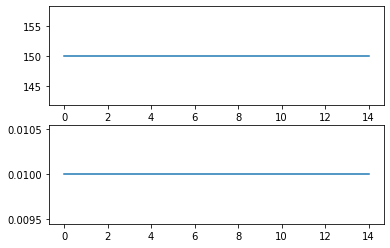

<function print>

In [58]:
#plotting

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

if one_d:
    x1 = np.linspace(0,1,nb)
    ax1.plot(vars[0::nc])
    ax2.plot(vars[1::nc])
else: 
    z1 = np.reshape(vars[0::nc], [ny, nx])
    pl1 = ax1.imshow(z1)
    z1 = np.reshape(vars[1::nc], [ny, nx])
    pl2 = ax2.imshow(z1)
    
    fig.colorbar(pl1, ax=ax1)
    fig.colorbar(pl2, ax=ax2)
    
plt.show()
print